In this project, the aim is to predicting the response y based on nearly 800 features. The goal is to build a model that can accurately predict the response y of an observation given its features.


# Import Dependencies

In [1153]:
!pip install xgboost

In [1154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from eli5.sklearn import PermutationImportance
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
import xgboost as xgb

# Data Understanding

In [1155]:
train_df = pd.read_csv('fiverr_train.csv')
test_df = pd.read_csv('fiverr_test.csv')

In [1156]:
train_df.head(5)

id          x001      x002  x003     x004          x005  x006         x007  \
0   0  9.681860e+10   6991.15  7.76  0.00380  5.378811e+09  0.31    266117.20   
1   1  3.304810e+09  13914.43  5.37  0.00015  1.652405e+09  0.00  11927742.92   
2   2  3.218944e+10   3991.98  5.77  0.00010  2.476111e+09  0.00    774385.01   
3   3  1.288000e+10  15937.45  5.86  0.00020  2.146667e+09  0.00   6324375.16   
4   4  3.063412e+10   3621.00  7.52  0.00060  1.392460e+09  0.21    169860.29   

        x008       x009  ...    x757           x758  x759   x760  x761   x762  \
0   934577.0    14539.0  ...  0.0007      297281012  0.13    5.0     5    2.0   
1  1798051.0  1051272.0  ...  0.1136  3320000000000  0.08  661.0     0  350.0   
2   375738.0   144143.0  ...  0.0029      100474819  0.39   39.0     2   18.0   
3  1932094.0    10055.0  ...  0.0000   348000000000  0.25    2.0     1    0.0   
4   474253.0    17914.0  ...  0.0005      109546590  0.11   11.0     1    3.0   

      x763    x764  x765   y  
0   8.5127   14.28 -0.75   5  
1   1.5700  160.12   NaN   1  
2   9.6800   25.06 -0.49  11  
3   4.5316  117.76  1.64   1  
4  16.2717    5.81 -0.42   5  

[5 rows x 767 columns]

In [1157]:
test_df.head(5)

id          x001      x002  x003     x004          x005  x006  \
0  5380  6.507826e+10   7882.15  6.82  0.00210  1.712586e+09  0.39   
1  5381  3.122741e+09   4682.13  8.17  0.00010  1.040914e+09  0.00   
2  5382  3.888719e+10   7495.57  7.15  0.00285  2.160400e+09  0.42   
3  5383  7.727427e+10   4003.76  6.53  0.00165  5.519591e+09  0.00   
4  5384  4.184868e+09  34874.72  6.39  0.00065  1.046217e+09  0.50   

         x007       x008      x009  ...    x756    x757            x758  x759  \
0   583617.74   862986.0   63872.0  ...  0.0380  0.0010     90204869909  0.26   
1   190000.65   688710.0   35407.0  ...  0.1866  0.0192     37449565014  0.02   
2   351570.67   841523.0  170240.0  ...  0.0100  0.0017     10847937619  0.83   
3   320216.05   466131.0      35.0  ...  0.4636  0.0000        37200096  0.51   
4  3349978.53  3711028.0    1757.0  ...  2.8737  0.0001  16400000000000  0.12   

   x760  x761  x762     x763    x764   x765  
0   8.0     5   5.0  30.1213   27.95  -0.49  
1  16.0     1   8.0   2.1282   10.18   0.55  
2  35.0     1  19.0   7.8513   21.27  19.09  
3   1.0     4   0.0   9.0511   18.38   4.11  
4   2.0     1   2.0   2.6512  149.68   0.02  

[5 rows x 766 columns]

In [1158]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5380 entries, 0 to 5379
Columns: 767 entries, id to y
dtypes: float64(657), int64(99), object(11)
memory usage: 31.5+ MB


In [1159]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4403 entries, 0 to 4402
Columns: 766 entries, id to x765
dtypes: float64(657), int64(98), object(11)
memory usage: 25.7+ MB


There are no categorical variables. 

# Check for duplicates

In [1160]:
train_df.duplicated().any()

False

In [1161]:
test_df.duplicated().any()

False

# Missing Value Detection & Treatment

In [1162]:
train_df.isnull().sum()

id        0
x001     10
x002      0
x003      3
x004      0
       ... 
x762     53
x763      0
x764      3
x765    375
y         0
Length: 767, dtype: int64

In [1163]:
test_df.isnull().sum()

id        0
x001     23
x002      0
x003      4
x004      0
       ... 
x761      0
x762     46
x763      0
x764      4
x765    272
Length: 766, dtype: int64

In [1164]:
# Check which columns are having missing values 
columns_with_missing_values = train_df.columns[train_df.isnull().any()].tolist()

print("Columns with missing values:")
print(columns_with_missing_values)

Columns with missing values:
['x001', 'x003', 'x005', 'x007', 'x008', 'x009', 'x011', 'x012', 'x015', 'x016', 'x017', 'x018', 'x021', 'x023', 'x024', 'x026', 'x027', 'x028', 'x030', 'x031', 'x035', 'x037', 'x038', 'x043', 'x044', 'x047', 'x048', 'x049', 'x050', 'x051', 'x052', 'x053', 'x055', 'x056', 'x057', 'x058', 'x059', 'x060', 'x061', 'x062', 'x064', 'x065', 'x066', 'x068', 'x069', 'x070', 'x071', 'x074', 'x075', 'x076', 'x077', 'x078', 'x080', 'x081', 'x082', 'x083', 'x084', 'x087', 'x089', 'x090', 'x095', 'x099', 'x100', 'x103', 'x104', 'x106', 'x107', 'x108', 'x110', 'x111', 'x112', 'x113', 'x116', 'x117', 'x119', 'x120', 'x123', 'x124', 'x125', 'x126', 'x127', 'x129', 'x130', 'x131', 'x132', 'x133', 'x134', 'x135', 'x136', 'x138', 'x139', 'x140', 'x141', 'x142', 'x143', 'x144', 'x145', 'x147', 'x148', 'x150', 'x152', 'x153', 'x157', 'x158', 'x159', 'x160', 'x162', 'x163', 'x165', 'x166', 'x167', 'x168', 'x169', 'x170', 'x172', 'x173', 'x174', 'x176', 'x177', 'x178', 'x179', 'x

In [1165]:
#percentage of missing values in train_df 

missing_percentages = train_df.isnull().sum()/ len(train_df) * 100 

print(missing_percentages)

id      0.000000
x001    0.185874
x002    0.000000
x003    0.055762
x004    0.000000
          ...   
x762    0.985130
x763    0.000000
x764    0.055762
x765    6.970260
y       0.000000
Length: 767, dtype: float64


In [1166]:
#delete the columns that are having more than 30% missing values 

columns_to_delete = missing_percentages[missing_percentages > 30].index

train_df = train_df.drop(columns=columns_to_delete)


In [1167]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5380 entries, 0 to 5379
Columns: 767 entries, id to y
dtypes: float64(657), int64(99), object(11)
memory usage: 31.5+ MB


No columns were removed as the missing values are less than 30%

In [1168]:
#percentage of missing values in test_df 

missing_percentages = test_df.isnull().sum()/ len(test_df) * 100 

print(missing_percentages)

id      0.000000
x001    0.522371
x002    0.000000
x003    0.090847
x004    0.000000
          ...   
x761    0.000000
x762    1.044742
x763    0.000000
x764    0.090847
x765    6.177606
Length: 766, dtype: float64


In [1169]:
#delete the columns that are having more than 30% missing values 


columns_to_delete = missing_percentages[missing_percentages > 30].index

test_df = test_df.drop(columns=columns_to_delete)


In [1170]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4403 entries, 0 to 4402
Columns: 766 entries, id to x765
dtypes: float64(657), int64(98), object(11)
memory usage: 25.7+ MB


##  Check the skewness 

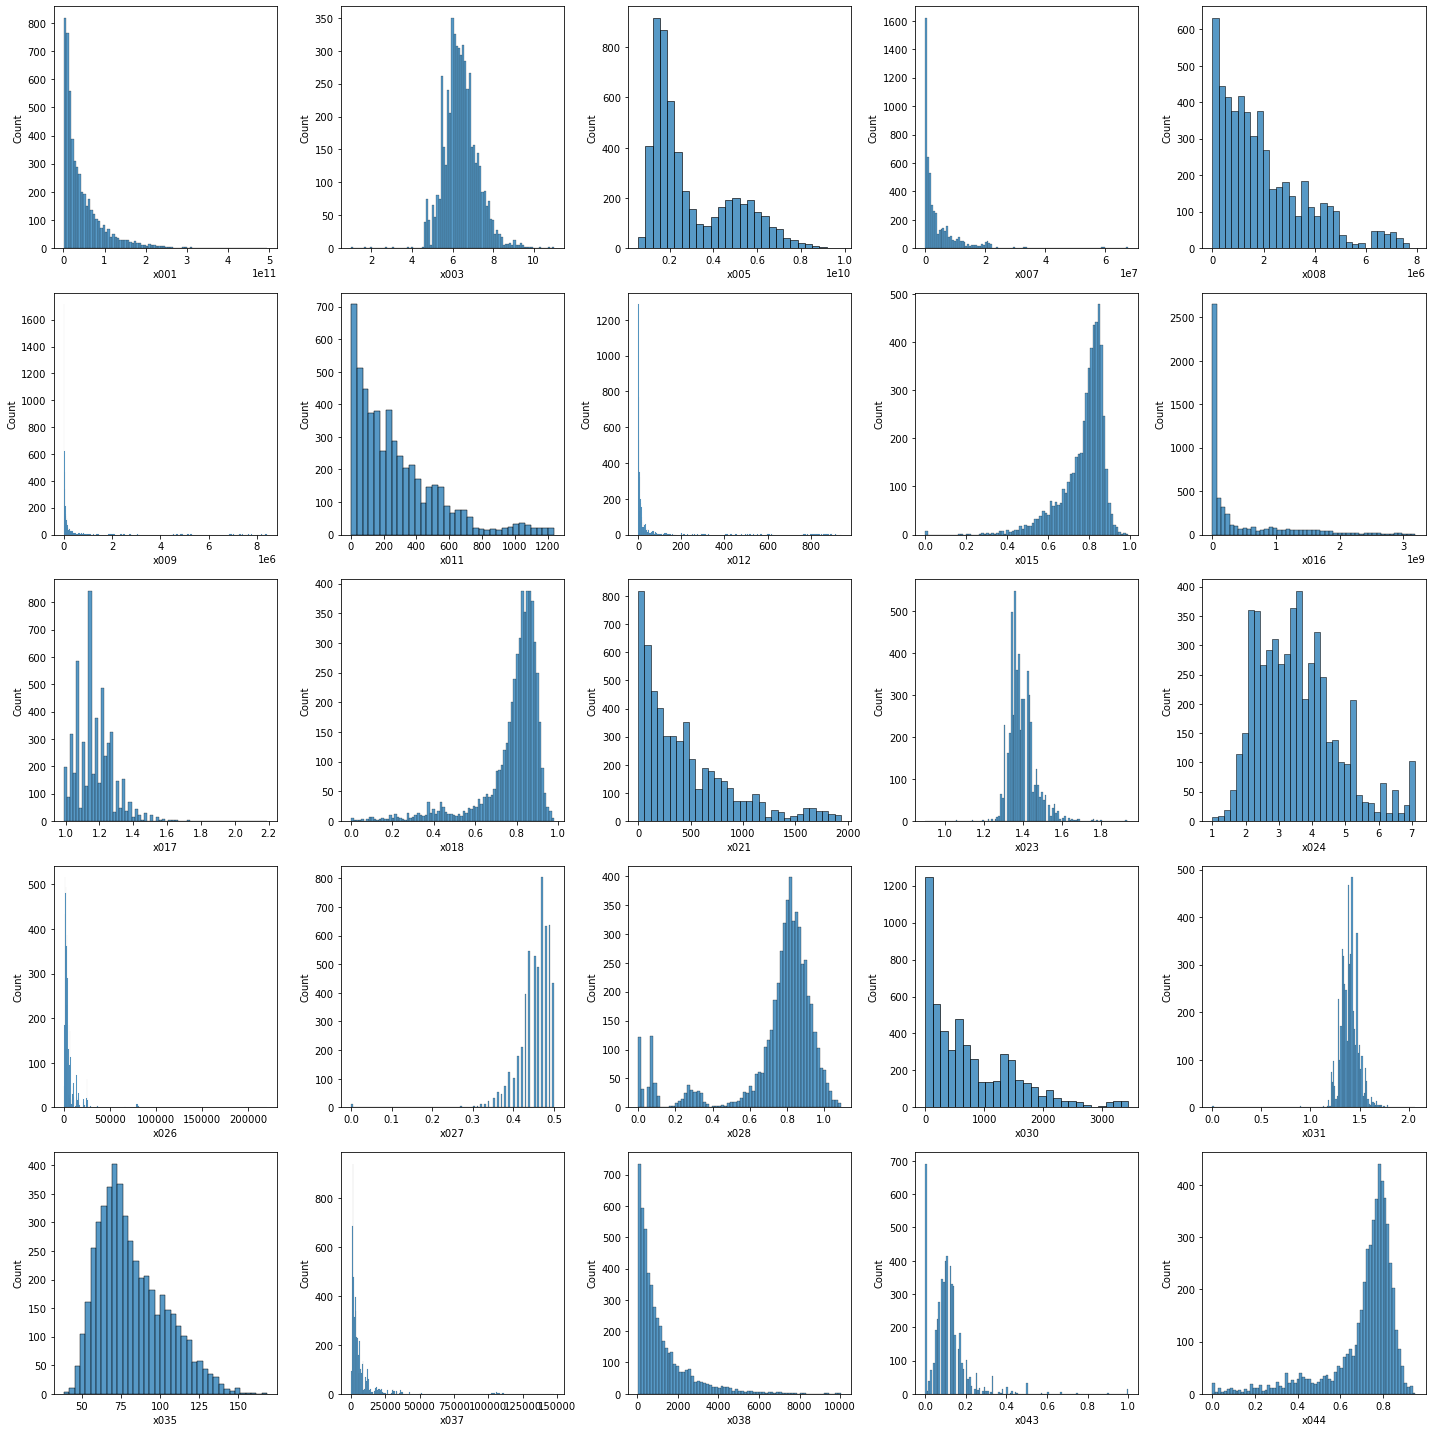

In [1171]:
numcols_with_missing_values = train_df.columns[train_df.isnull().any()].tolist()

rows = 5
cols = 5

plt.figure(figsize=(20, 20))

counter = 1
for col in numcols_with_missing_values:
    if counter > rows * cols:
        break
    
    plt.subplot(rows, cols, counter)
    sns.histplot(train_df[col])
    counter += 1

plt.tight_layout()
plt.show()


Since a portion (majority) of the features that are having missing values are highly skewed. We will use median imputation to treat all of the missing values in different columns

# Median imputation

## Train_df

In [1172]:
df_filled = train_df.fillna(train_df.median())

# Check if any missing values remain
print(df_filled.isnull().sum())


id      0
x001    0
x002    0
x003    0
x004    0
       ..
x762    0
x763    0
x764    0
x765    0
y       0
Length: 767, dtype: int64


In [1173]:
train_df = df_filled

## Test_df

In [1174]:
df_filled2 = test_df.fillna(test_df.median())

# Check if any missing values remain
print(df_filled2.isnull().sum())


id      0
x001    0
x002    0
x003    0
x004    0
       ..
x761    0
x762    0
x763    0
x764    0
x765    0
Length: 766, dtype: int64


In [1175]:
test_df = df_filled2

## Check if there is still missing value

In [1176]:
print(train_df.isnull().values.sum() !=0)

False


In [1177]:
print(test_df.isnull().values.sum() !=0)

False


# Save a copy of Test_id 

In [1178]:
test_id = test_df.copy()

# Correlation

In [1179]:
train_df.corr()

id      x001      x002      x003      x004      x005      x006  \
id    1.000000  0.014507 -0.001859  0.001667  0.004353  0.024302  0.014469   
x001  0.014507  1.000000 -0.102207  0.152371  0.379722  0.493345  0.247461   
x002 -0.001859 -0.102207  1.000000 -0.177172  0.035330 -0.179638  0.071401   
x003  0.001667  0.152371 -0.177172  1.000000 -0.066532 -0.053509 -0.113403   
x004  0.004353  0.379722  0.035330 -0.066532  1.000000  0.231497  0.222151   
...        ...       ...       ...       ...       ...       ...       ...   
x762 -0.018689 -0.057593  0.101492 -0.234787  0.046615  0.042605  0.098667   
x763 -0.009983  0.629060  0.017972  0.204250  0.225874 -0.127589  0.226026   
x764 -0.006770 -0.149293  0.819372 -0.500837  0.086364 -0.025655  0.116186   
x765  0.001854  0.009969 -0.024150  0.005023  0.011193  0.064671  0.002253   
y    -0.018863  0.002445 -0.065831  0.201162 -0.021558 -0.060874 -0.122274   

          x007      x008      x009  ...      x757      x758      x759  \
id   -0.003572 -0.001592 -0.023318  ... -0.014413  0.009485  0.008225   
x001 -0.165516 -0.103672 -0.031840  ... -0.052069 -0.006744 -0.016506   
x002  0.463655  0.961062  0.103669  ...  0.058053  0.104158  0.045776   
x003 -0.500057 -0.197888 -0.177781  ... -0.252383 -0.137514 -0.091622   
x004  0.126864  0.075835  0.038995  ...  0.082101  0.021076  0.011459   
...        ...       ...       ...  ...       ...       ...       ...   
x762  0.364777  0.150772  0.942318  ...  0.840893  0.228126  0.042649   
x763 -0.154838 -0.019099 -0.084744  ... -0.100417 -0.086515 -0.037551   
x764  0.741622  0.853020  0.244564  ...  0.250753  0.210066  0.094299   
x765 -0.020909 -0.015886 -0.009844  ... -0.009297 -0.001628 -0.031935   
y    -0.109856 -0.074440 -0.050121  ... -0.059782 -0.107359 -0.117110   

          x760      x761      x762      x763      x764      x765         y  
id   -0.018865  0.000953 -0.018689 -0.009983 -0.006770  0.001854 -0.018863  
x001 -0.056963  0.602159 -0.057593  0.629060 -0.149293  0.009969  0.002445  
x002  0.102545 -0.007468  0.101492  0.017972  0.819372 -0.024150 -0.065831  
x003 -0.232226  0.159333 -0.234787  0.204250 -0.500837  0.005023  0.201162  
x004  0.044747  0.186038  0.046615  0.225874  0.086364  0.011193 -0.021558  
...        ...       ...       ...       ...       ...       ...       ...  
x762  0.999511 -0.082136  1.000000 -0.100423  0.272393 -0.015294 -0.062718  
x763 -0.098238  0.794701 -0.100423  1.000000 -0.141722 -0.016660  0.009145  
x764  0.270010 -0.133993  0.272393 -0.141722  1.000000 -0.024196 -0.129009  
x765 -0.015601 -0.003590 -0.015294 -0.016660 -0.024196  1.000000  0.062452  
y    -0.062881 -0.019237 -0.062718  0.009145 -0.129009  0.062452  1.000000  

[756 rows x 756 columns]

In [1180]:
correlation_matrix = train_df.corr().abs()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

high_corr_features = correlation_matrix.mask(mask).stack().sort_values(ascending=False)

threshold = 0.91  # Define the correlation threshold above which features should be removed

# Identify the feature pairs to be removed
feature_pairs_to_remove = high_corr_features[high_corr_features > threshold].index

# Remove the features from the DataFrame
train_df.drop(columns=[pair[1] for pair in feature_pairs_to_remove], inplace=True)


In [1181]:
threshold = 0.91  # Define the correlation threshold above which features should be removed

# Identify the feature pairs to be removed
feature_pairs_to_remove = high_corr_features[high_corr_features > threshold].index

# Remove the features from the test_df DataFrame
test_df.drop(columns=[pair[1] for pair in feature_pairs_to_remove], inplace=True)


# Skewness

In [1182]:
# Calculate skewness for each column
skewness = train_df[train_df.columns].skew()

skewness

id      0.000000
x003    0.384679
x006   -0.489697
x014    0.935460
x022   -1.067442
          ...   
x762    5.047716
x763    2.513185
x764    1.384613
x765    6.147502
y       4.230155
Length: 334, dtype: float64

# Data Standardization and Splitting of data

In [1183]:
X=train_df.drop('y', axis=1)
y=train_df[['y']]

In [1184]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=10)

In [1185]:
print( X_train.shape, X_test.shape)

(3766, 333) (1614, 333)


In [1186]:
scaler = StandardScaler()

In [1187]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
test_df = scaler.fit_transform(test_df)

# Dimensional Reduction 

In [1188]:
# Create a PCA instance
pca = PCA(n_components=12)

# Fit the PCA on the training data
pca.fit(X_train)

# Transform the training and test data using the fitted PCA model
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
test_df = pca.transform(test_df)

# Random Forest

In [1189]:
y_train = np.ravel(y_train)

In [1190]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [1191]:
# Make predictions on the val set
y_pred = rf_model.predict(X_test)

In [1192]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 11.397222264252298


# Hyperparameter tuning (RF) 


In [1193]:
# Define the parameter grid for random search
param_grid = {
    'n_estimators': randint(100, 1000),  # Number of trees in the forest
    'max_depth': randint(2, 20),         # Maximum depth of the trees
    'min_samples_split': randint(2, 10),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 10),   # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]            # Whether bootstrap samples are used when building trees
}

# Create a Random Forest Regressor instance
rf_model = RandomForestRegressor(random_state=42)

# Perform random search cross-validation
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Evaluation metric to optimize
    cv=5,       # Number of cross-validation folds
    random_state=42
)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_


In [1194]:
best_params
best_model

RandomForestRegressor(bootstrap=False, max_depth=16, max_features='log2',
                      min_samples_leaf=8, min_samples_split=8, n_estimators=134,
                      random_state=42)

## RF2 model

In [1198]:
rf2_model = RandomForestRegressor(bootstrap=False, max_depth=16, max_features='log2',
                      min_samples_leaf=8, min_samples_split=8, n_estimators=134,
                      random_state=42)
rf2_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=16, max_features='log2',
                      min_samples_leaf=8, min_samples_split=8, n_estimators=134,
                      random_state=42)

In [1199]:
# Make predictions on the test set
y2_pred = rf2_model.predict(X_test)

In [1200]:
mse = mean_squared_error(y_test, y2_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 11.150099327974617


# Ridge Regression

In [1201]:
# Define the parameter grid for random search
param_grid = {
    'alpha': [0.1, 1.0, 10.0],          # Regularization strength
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']  # Solvers to use
}

# Create a Ridge Regressor instance
ridge_model = Ridge()

# Perform random search cross-validation
random_search = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Evaluation metric to optimize
    cv=5,       # Number of cross-validation folds
    random_state=42
)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params2 = random_search.best_params_
best_model2 = random_search.best_estimator_

# Make predictions on the test set using the best model
y_2pred = best_model2.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


Mean Squared Error: 129.89667534076827
Best Hyperparameters: {'bootstrap': False, 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 134}


In [1202]:
# Calculate RMSE
mse = mean_squared_error(y_test, y_2pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 11.366876204956268


# Lasso Regression

In [1203]:
# Define the parameter grid for random search
param_grid = {
    'alpha': [0.1, 1.0, 10.0],          # Regularization strength
    'selection': ['cyclic', 'random']   # Strategy for coordinate descent
}

# Create a Lasso Regressor instance
lasso_model = Lasso()

# Perform random search cross-validation
random_search = RandomizedSearchCV(
    estimator=lasso_model,
    param_distributions=param_grid,
    n_iter=6,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Evaluation metric to optimize
    cv=5,       # Number of cross-validation folds
    random_state=42
)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params3 = random_search.best_params_
best_model3 = random_search.best_estimator_

# Make predictions on the test set using the best model
y3_pred = best_model3.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


Mean Squared Error: 129.89667534076827
Best Hyperparameters: {'bootstrap': False, 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 134}


In [1204]:
# Calculate RMSE
mse = mean_squared_error(y_test, y3_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 11.36539143077307


# Neural Network

In [1205]:
# Determine the number of input features
input_dim = X_train.shape[1]

# Create a function to build the neural network model
def create_model(hidden_units=32, activation='relu', optimizer='adam', dropout=0.0):
    model = Sequential()
    model.add(Dense(hidden_units, activation=activation, input_dim=input_dim))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create the KerasRegressor wrapper
model = KerasRegressor(build_fn=create_model)

# Define the hyperparameter grid for tuning
param_grid = {
    'hidden_units': [64, 128],  # Number of units in the hidden layer
    'epochs': [50, 100],  # Number of training epochs
    'batch_size': [32, 64],  # Number of samples per gradient update
    'activation': ['relu', 'sigmoid'],  # Activation function for the hidden layer
    'optimizer': ['adam', 'rmsprop'],  # Optimization algorithm
    'dropout': [0.0, 0.2,0.3, 0.5]  # Dropout rate to reduce overfitting
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model4 = grid_search.best_estimator_
best_params4 = grid_search.best_params_

# Make predictions using the best model
y4_pred = best_model4.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Epoch 1/50


C:\Users\User\AppData\Local\Temp\ipykernel_2868\3765289217.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model)


95/95 [==============================] - 1s 925us/step - loss: 124.9056
Epoch 2/50
95/95 [==============================] - 0s 830us/step - loss: 104.5243
Epoch 3/50
95/95 [==============================] - 0s 809us/step - loss: 101.9139
Epoch 4/50
95/95 [==============================] - 0s 755us/step - loss: 100.5892
Epoch 5/50
95/95 [==============================] - 0s 755us/step - loss: 98.9679
Epoch 6/50
95/95 [==============================] - 0s 990us/step - loss: 98.1423
Epoch 7/50
95/95 [==============================] - 0s 883us/step - loss: 97.1191
Epoch 8/50
95/95 [==============================] - 0s 862us/step - loss: 96.3992
Epoch 9/50
95/95 [==============================] - 0s 904us/step - loss: 94.9841
Epoch 10/50
95/95 [==============================] - 0s 1ms/step - loss: 94.2335
Epoch 11/50
95/95 [==============================] - 0s 1ms/step - loss: 93.3013
Epoch 12/50
95/95 [==============================] - 0s 947us/step - loss: 93.1448
Epoch 13/50
95/95 [=====

In [1206]:
# Calculate RMSE
mse = mean_squared_error(y_test, y4_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 11.050929640726679


# XGBoosting model

In [1207]:
# Define the XGBoost model
model = xgb.XGBRegressor()

# Define the range of hyperparameters to search over
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Create the grid search object
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameter configuration
best_params = grid_search.best_params_

# Fit the model with the best hyperparameters
best_model5 = xgb.XGBRegressor(**best_params)
best_model5.fit(X_train, y_train)

# Evaluate the model on the test set
y5_pred = best_model5.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Best Model MSE on Test Set:", mse)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best Model MSE on Test Set: 129.89667534076827


In [1208]:
# Calculate RMSE
mse = mean_squared_error(y_test, y5_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 11.179417402462006


# Make predictions submission

In [1212]:
predictions = best_model4.predict(test_df)

69/69 [==============================] - 0s 632us/step


In [1213]:
predictions

array([ 8.915413, 13.410232,  7.733054, ...,  8.457838, 10.335608,
        7.814517], dtype=float32)

In [1214]:
submission = pd.DataFrame()
submission['id'] = test_id['id']
submission['y'] = predictions

# save the submission file as a CSV file
submission.to_csv('submission.csv', index=False)

# END 